In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
sys.path.append("C:/dev/pyktrader3/")
from pycmqlib3.utility import misc
from bktest import backtest
import pycmqlib3.analytics.data_handler as dh

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc'] #, 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'CY', 'SR', 'jd', 'AP'] #, 'sp', 'CJ', 'UR']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts
sim_start_dict = { 'c': datetime.date(2008,10,1), 'm': datetime.date(2010,10,1),
    'y': datetime.date(2010,1,1), 'l': datetime.date(2008,1,1), 'rb':datetime.date(2010,1,1),
    'p': datetime.date(2010,1,1), 'cu':datetime.date(2010,1,1), 'al':datetime.date(2010,1,1),
    'zn':datetime.date(2010,1,1), 'au':datetime.date(2010,1,1), 'v': datetime.date(2010,1,1),
    'a': datetime.date(2010,1,1), 'ru':datetime.date(2010,1,1), 'ag':datetime.date(2012,7,6),
    'i': datetime.date(2013,12,13), 'j': datetime.date(2011,6,14), 'jm':datetime.date(2013,5,24),
    'CF':datetime.date(2008,1,1),  'TA':datetime.date(2007,2,15),
    'PM':datetime.date(2012,10,1), 'RM':datetime.date(2013,3,16),  'SR':datetime.date(2006,1,6),
    'FG':datetime.date(2013,2,1),  'OI':datetime.date(2013,6,1),  'RI':datetime.date(2013,6,1),
    'WH':datetime.date(2014,2,1),  'pp':datetime.date(2014,4,28),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2011,12,23),  'TF':datetime.date(2014,4,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,17),
    'jd':datetime.date(2014,1,6),  'ni':datetime.date(2015,5,26),  'sn':datetime.date(2015,6,8),
    'ZC':datetime.date(2013,12,28), 'hc':datetime.date(2014, 5, 21), 'SM': datetime.date(2016,11,21),
    'SF': datetime.date(2017,5,17), 'CY': datetime.date(2017, 7, 17), 'AP': datetime.date(2018, 2, 26),
    'TS': datetime.date(2018, 8, 17), 'fu': datetime.date(2018, 7, 16), 'sc': datetime.date(2018, 5, 25),
    'b': datetime.date(2017, 12, 26), 'pb': datetime.date(2011, 5, 24), 'bu': datetime.date(2015,11,1),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 4, 1), 'sp': datetime.date(2019, 1, 24),
    'CJ': datetime.date(2019, 8, 1), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2019, 12, 9),
    'eb': datetime.date(2019, 12, 1), 'eg': datetime.date(2019, 2, 13), 'rr': datetime.date(2019, 8, 19),
    'pg': datetime.date(2020, 10, 1), 'lu': datetime.date(2020, 8, 1),}

In [3]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2021, 3, 26)
pnl_tenors = ['1y', '2y', '3y', '4y', '5y', '6y', '8y', '10y']

sim_products = commod_all_mkts
need_shift = 1
freq = 'd'
delim = '-'
dbtbl_prefix = ''
args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
sc_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
bond_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}

df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['sc']:
        use_args = sc_args  
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [delim.join((asset, col)) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).sort_index()
print(df.tail(20))

loading mkt = rb, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2010, 1, 1), 'end_date': datetime.date(2021, 3, 26)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2014, 5, 21), 'end_date': datetime.date(2021, 3, 26)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2013, 12, 13), 'end_date': datetime.date(2021, 3, 26)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2011, 6, 14), 'end_date': datetime.date(2021, 3, 26)}
loading mkt = jm, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2013, 5, 24), 'end_date': datetime.date(2021, 3, 26)}
loading mkt = ru, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd',

In [4]:
def run_xs_test(input_args):
    product_list = input_args['product_list']
    mom_win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    quantile_cutoff = input_args.get('quantile', 0.2)
    run_mode = input_args.get('run_mode', "momma")
    params = input_args.get('params', [0.2])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    select_cols = []
    rank_field = ""
    for col in df.columns:
        col_split = col.split(delim)
        if col_split[0] in product_list:
            select_cols.append(col)
    xdf= df[select_cols].sort_index().fillna(method='ffill').copy()
    if start_date:
        xdf = xdf[xdf.index>= start_date]
    if end_date:
        xdf = xdf[xdf.index<= end_date]
        
    for asset in product_list:
        if need_shift == 1:
            xdf[delim.join((asset, 'lr'))] = np.log(xdf[delim.join((asset, 'close'))] -xdf[delim.join((asset, 'shift'))])- np.log(xdf[delim.join((asset, 'close'))].shift(1) -xdf[delim.join((asset, 'shift'))])
        else:
            xdf[delim.join((asset, 'lr'))] = \
                np.log(xdf[delim.join((asset, 'close'))])- np.log(xdf[delim.join((asset, 'close'))].shift(1))
        if run_mode == 'mom':
            xdf[delim.join((asset, 'mom'))] =  xdf[delim.join((asset, 'lr'))].rolling(mom_win).sum()
            rank_field = "mom"
        if run_mode == 'momma':
            xdf[delim.join((asset, 'momma'))] =  xdf[delim.join((asset, 'lr'))].rolling(mom_win).sum().rolling(ma_win).mean()
            rank_field = "momma"
        elif run_mode == 'rsima':
            rsi_output = dh.RSI_F(xdf, mom_win, prefix = asset + delim)
            xdf[delim.join((asset, 'rsi'))] = rsi_output[asset + delim + 'RSI' + str(mom_win)]
            xdf[delim.join((asset, 'rsima'))] = dh.EMA(xdf, ma_win, field = 'rsi', prefix = asset + delim)
            rank_field = "rsima"
        elif run_mode == 'madist':
            xdf[delim.join((asset, 'ema1'))] = dh.EMA(xdf, mom_win, field = 'close', prefix = asset + delim)
            xdf[delim.join((asset, 'ema2'))] = dh.EMA(xdf, int(mom_win * params[0]), field = 'close', prefix = asset + delim)
            xdf[delim.join((asset, 'std'))] = dh.STDEV(xdf, ma_win, field = 'close', prefix = asset + delim)
            xdf[delim.join((asset, 'madist'))] = (xdf[delim.join((asset, 'ema1'))] - xdf[delim.join((asset, 'ema2'))])/xdf[delim.join((asset, 'std'))]
            xdf[delim.join((asset, 'nmadist'))] = xdf[delim.join((asset, 'madist'))]/dh.STDEV(xdf, int(ma_win * params[1]), field = 'madist', prefix = asset + delim)
            xdf[delim.join((asset, 'sig'))] = xdf[delim.join((asset, 'nmadist'))].apply(lambda x: dh.response_curve(x, "absorbing", param = 2.0))
            rank_field = "sig"
        if need_shift == 1:        
            orig_close = xdf[delim.join((asset, 'close'))] -xdf[delim.join((asset, 'shift'))]
            if pos_std == 1:
                xdf[delim.join((asset, 'std'))] = dh.ATR(df, vol_win, prefix = asset + delim).fillna(method='bfill') * 10.0
            else:
                xdf[delim.join((asset, 'std'))] = orig_close
        elif need_shift == 2:
            orig_close = xdf[delim.join((asset, 'close'))] * np.exp(-xdf[delim.join((asset, 'shift'))])
            if pos_std == 1:
                xdf[delim.join((asset, 'std'))] = (np.log(xdf[delim.join((asset, 'close'))]) \
                                - np.log(xdf[delim.join((asset, 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close * 10
            else:
                xdf[delim.join((asset, 'std'))] = orig_close
        else:
            orig_close = xdf[delim.join((asset, 'close'))]
            xdf[delim.join((asset, 'std'))] = orig_close
        
    total_risk = 5000000.0
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0

    xdf['rebal_seqno'] = range(len(xdf.index))

    rank_df = xdf[[delim.join((asset, rank_field)) for asset in product_list]].rank(axis=1)
    rank_df.columns = product_list
    
    xdf['prod_count'] = rank_df.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1).fillna(0)
    xdf['kcut'] = (xdf['prod_count'] * quantile_cutoff).astype('int')
    xdf['upper_rank'] = xdf['prod_count'] - xdf['kcut']
    xdf['lower_rank'] = xdf['kcut'] + 1 
    
    long_pos = pd.DataFrame(0, columns = product_list, index = xdf.index)
    short_pos = pd.DataFrame(0, columns = product_list, index = xdf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in product_list:
            long_tmp.loc[(rank_df[asset]>xdf['upper_rank']) & rebal_flag, asset] = 1.0
            long_tmp.loc[(rank_df[asset]<=xdf['upper_rank']) & rebal_flag, asset] = 0.0
            short_tmp.loc[(rank_df[asset]<xdf['lower_rank']) & rebal_flag, asset] = 1.0
            short_tmp.loc[(rank_df[asset]>=xdf['lower_rank']) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_sum = long_tmp.sum(axis=1)
        short_sum = short_tmp.sum(axis=1)
        long_pos = long_pos + long_tmp.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp.div(short_sum,axis=0)
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []

    for asset, offset in zip(product_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk / rebal_freq \
                    /xdf[delim.join((asset,'std'))].astype('float')).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk / rebal_freq \
                    /xdf[delim.join((asset,'std'))].astype('float')).shift(1).fillna(method='ffill')
        xdf[delim.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        xdf[delim.join((asset, 'traded_price'))] = xdf[delim.join((asset, 'open'))]
        xdf[delim.join((asset, 'pos'))].iloc[-1] = 0
        xdf[delim.join((asset, 'cost'))] = \
                abs(xdf[delim.join((asset, 'pos'))] \
                - xdf[delim.join((asset, 'pos'))].shift(1)) * offset
        xdf[delim.join((asset, 'cost'))] = xdf[delim.join((asset, 'cost'))].fillna(0.0)
        fields = [delim.join((asset, field)) for field in extract_fields] 
        tdf = xdf[fields]
        tdf.columns = extract_fields
        tdf.index.name = 'date'    
        if freq == 'm':
            tdf['date'] = xdf['date']
            tdf['min_id'] = xdf['min_id']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df = xdf[[delim.join((asset, 'pos')) for asset in product_list]]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df}
    return res

<ipython-input-5-fb0d8f5d7594>:48: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  port_pnl = pd.Series()
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


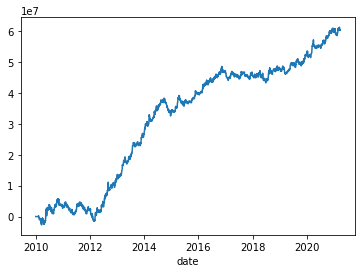

                 mom-commod_mkts-20-1-5
sharp_ratio_10y                1.327567
sharp_ratio_1y                 1.178177
sharp_ratio_2y                 1.736383
sharp_ratio_3y                 1.199981
sharp_ratio_4y                 0.850058
sharp_ratio_5y                 0.883933
sharp_ratio_6y                 0.991561
sharp_ratio_8y                 1.289999
std_pnl_10y               286619.712086
std_pnl_1y                269417.224451
std_pnl_2y                267183.917710
std_pnl_3y                273002.780054
std_pnl_4y                263746.305251
std_pnl_5y                267799.253581
std_pnl_6y                267343.415513
std_pnl_8y                276981.557231


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


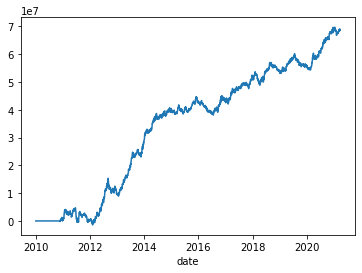

                 mom-commod_mkts-210-1-5
sharp_ratio_10y                 1.394298
sharp_ratio_1y                  2.015030
sharp_ratio_2y                  1.593296
sharp_ratio_3y                  1.367332
sharp_ratio_4y                  1.268376
sharp_ratio_5y                  1.199200
sharp_ratio_6y                  1.079998
sharp_ratio_8y                  1.479609
std_pnl_10y                309191.250779
std_pnl_1y                 313733.751361
std_pnl_2y                 298842.551420
std_pnl_3y                 296854.316807
std_pnl_4y                 294564.085507
std_pnl_5y                 304320.447790
std_pnl_6y                 296758.126363
std_pnl_8y                 306156.583035


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


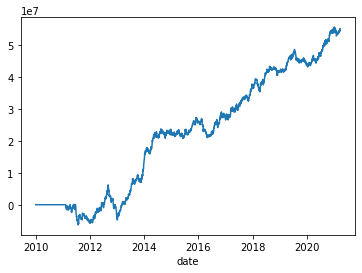

                 momma-commod_mkts-140-120-5
sharp_ratio_10y                     1.196926
sharp_ratio_1y                      1.962773
sharp_ratio_2y                      1.433584
sharp_ratio_3y                      1.413118
sharp_ratio_4y                      1.443514
sharp_ratio_5y                      1.419986
sharp_ratio_6y                      1.201242
sharp_ratio_8y                      1.476436
std_pnl_10y                    304323.179147
std_pnl_1y                     291420.957929
std_pnl_2y                     288332.142830
std_pnl_3y                     282878.168478
std_pnl_4y                     285176.441086
std_pnl_5y                     292398.592270
std_pnl_6y                     292613.910166
std_pnl_8y                     301015.319481


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


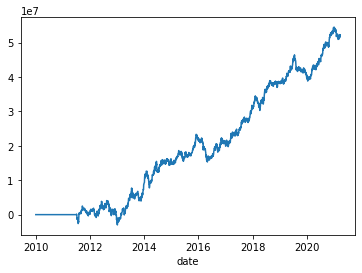

                 momma-commod_mkts-240-120-5
sharp_ratio_10y                     1.085896
sharp_ratio_1y                      2.004311
sharp_ratio_2y                      1.404631
sharp_ratio_3y                      1.419178
sharp_ratio_4y                      1.560982
sharp_ratio_5y                      1.396322
sharp_ratio_6y                      1.232454
sharp_ratio_8y                      1.297797
std_pnl_10y                    314432.014016
std_pnl_1y                     299587.731399
std_pnl_2y                     304412.096278
std_pnl_3y                     311701.040541
std_pnl_4y                     307522.337143
std_pnl_5y                     310615.518964
std_pnl_6y                     310015.169078
std_pnl_8y                     320133.679956


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


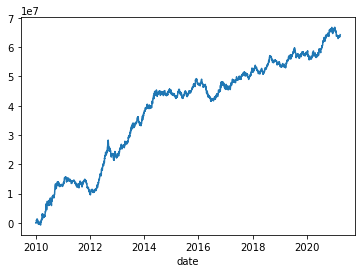

                 rsima-commod_mkts-70-60-5
sharp_ratio_10y                   1.074920
sharp_ratio_1y                    1.333184
sharp_ratio_2y                    1.198620
sharp_ratio_3y                    1.002936
sharp_ratio_4y                    0.965915
sharp_ratio_5y                    0.786323
sharp_ratio_6y                    0.788992
sharp_ratio_8y                    1.038146
std_pnl_10y                  302037.073348
std_pnl_1y                   303069.811566
std_pnl_2y                   301860.013031
std_pnl_3y                   286533.832381
std_pnl_4y                   281938.708085
std_pnl_5y                   292231.690721
std_pnl_6y                   288319.464714
std_pnl_8y                   299794.411051


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


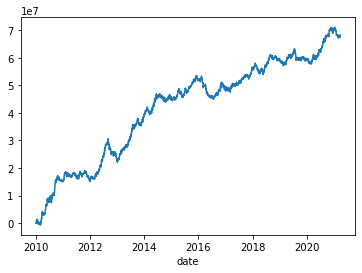

                 rsima-commod_mkts-100-80-5
sharp_ratio_10y                    1.121696
sharp_ratio_1y                     1.699444
sharp_ratio_2y                     1.111399
sharp_ratio_3y                     1.019711
sharp_ratio_4y                     1.066773
sharp_ratio_5y                     0.830946
sharp_ratio_6y                     0.810436
sharp_ratio_8y                     1.139694
std_pnl_10y                   296105.065340
std_pnl_1y                    308037.355210
std_pnl_2y                    304303.300867
std_pnl_3y                    292071.231506
std_pnl_4y                    284415.702460
std_pnl_5y                    290779.914208
std_pnl_6y                    290197.893088
std_pnl_8y                    297360.631757


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


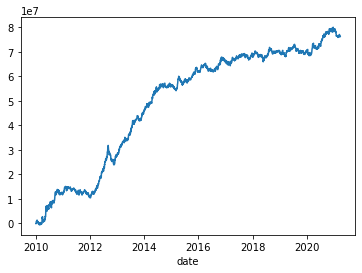

                 rsima-commod_mkts-90-10-5
sharp_ratio_10y                   1.324453
sharp_ratio_1y                    0.724782
sharp_ratio_2y                    0.865060
sharp_ratio_3y                    0.637209
sharp_ratio_4y                    0.590775
sharp_ratio_5y                    0.523058
sharp_ratio_6y                    0.751578
sharp_ratio_8y                    1.176650
std_pnl_10y                  304760.960617
std_pnl_1y                   319357.118532
std_pnl_2y                   304414.474554
std_pnl_3y                   294020.488884
std_pnl_4y                   286793.771237
std_pnl_5y                   295984.148237
std_pnl_6y                   292925.022768
std_pnl_8y                   300775.672496


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


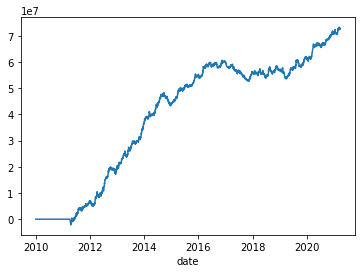

                 madist-commod_mkts-8-100-5
sharp_ratio_10y                    1.692066
sharp_ratio_1y                     1.917811
sharp_ratio_2y                     2.317371
sharp_ratio_3y                     1.349871
sharp_ratio_4y                     0.864779
sharp_ratio_5y                     0.764891
sharp_ratio_6y                     1.068340
sharp_ratio_8y                     1.484425
std_pnl_10y                   281011.827794
std_pnl_1y                    258889.073325
std_pnl_2y                    269527.670906
std_pnl_3y                    273371.406474
std_pnl_4y                    264734.836837
std_pnl_5y                    260788.234487
std_pnl_6y                    262208.782515
std_pnl_8y                    271706.626201


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


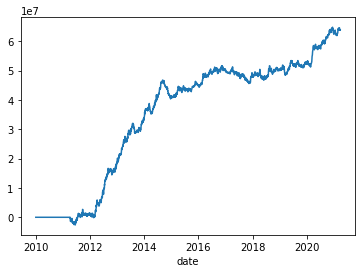

                 madist-commod_mkts-16-100-5
sharp_ratio_10y                     1.389804
sharp_ratio_1y                      1.541186
sharp_ratio_2y                      1.796051
sharp_ratio_3y                      1.192405
sharp_ratio_4y                      0.804618
sharp_ratio_5y                      0.768272
sharp_ratio_6y                      0.844685
sharp_ratio_8y                      1.126524
std_pnl_10y                    300066.425727
std_pnl_1y                     286080.741905
std_pnl_2y                     274007.924521
std_pnl_3y                     282157.360625
std_pnl_4y                     276961.602756
std_pnl_5y                     273645.763942
std_pnl_6y                     271170.272932
std_pnl_8y                     287054.394109


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


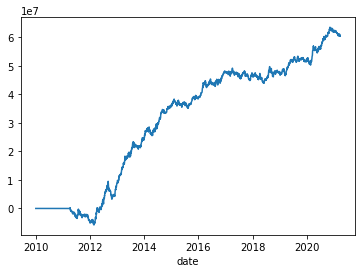

                 madist-commod_mkts-32-100-5
sharp_ratio_10y                     1.331831
sharp_ratio_1y                      1.142138
sharp_ratio_2y                      1.597894
sharp_ratio_3y                      1.207762
sharp_ratio_4y                      0.760205
sharp_ratio_5y                      0.814424
sharp_ratio_6y                      0.953940
sharp_ratio_8y                      1.301045
std_pnl_10y                    296604.779059
std_pnl_1y                     279891.336475
std_pnl_2y                     270916.582494
std_pnl_3y                     274655.242273
std_pnl_4y                     270913.167199
std_pnl_5y                     272764.387091
std_pnl_6y                     269951.926463
std_pnl_8y                     288580.935557


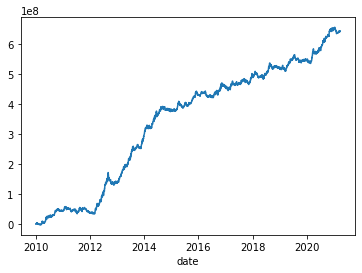

date
2021-02-08    6.348071e+08
2021-02-09    6.350898e+08
2021-02-10    6.352159e+08
2021-02-18    6.358103e+08
2021-02-19    6.364107e+08
2021-02-22    6.370210e+08
2021-02-23    6.386249e+08
2021-02-24    6.371018e+08
2021-02-25    6.373305e+08
2021-02-26    6.363358e+08
2021-03-01    6.375022e+08
2021-03-02    6.386179e+08
2021-03-03    6.395808e+08
2021-03-04    6.392345e+08
2021-03-05    6.394062e+08
2021-03-08    6.388853e+08
2021-03-09    6.412161e+08
2021-03-10    6.400321e+08
2021-03-11    6.412205e+08
2021-03-12    6.414869e+08
2021-03-15    6.414908e+08
2021-03-16    6.437942e+08
2021-03-17    6.411896e+08
2021-03-18    6.414201e+08
2021-03-19    6.396568e+08
2021-03-22    6.403930e+08
2021-03-23    6.403778e+08
2021-03-24    6.415939e+08
2021-03-25    6.420539e+08
2021-03-26    6.426261e+08
Name: daily_pnl, dtype: float64
                            0
sharp_ratio_10y  1.731953e+00
sharp_ratio_1y   1.902802e+00
sharp_ratio_2y   1.907736e+00
sharp_ratio_3y   1.541709e+00
sha

In [5]:
res = {}
stats_list = []
cum_list = []
sratio_years = [int(ten[:-1]) for ten in pnl_tenors]

mixed_metal_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'ni']
commod_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'ni', 'sn', \
               'l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'CF', 'SR', 'jd'] 

product_list =  commod_mkts 
#commod_mkts #ind_all_mkts + ags_all_mkts # ind_metal_mkts # commod_all_mkts #  ferrous_products_mkts # 
product_name = 'commod_mkts'
run_mode = 'madist'
start_date = datetime.date(2010,1,1)
end_date = datetime.date(2021,3,26)
cost_ratio = 0.5
pos_std = 1
std_win = 20
ma_win = 120
rebal = 5
quantile = 0.2
#save_loc = "C:\\dev\\data\\selected_xsmom_%s_" % ('_'.join([run_mode, product_name, str(quantile), str(end_date)]))
save_loc = "C:\\dev\\data\\combined_xsmom_%s_" % ('_'.join([product_name, str(quantile), str(end_date)]))

index_list = range(8, 88, 8) #range(10, 110, 10) #range(10, 250, 10) #  
column_list = [60, 80, 100, 120, 140, 160] #range(10, 90, 10) #range(10, 130, 10) #[1, 3, 5, 10, 15, 20] #[i * 0.01 for i in range(0, 32, 4)] # 
sratio = {}
run_sratio = False
run_pos_sum = True

pos_sum = pd.DataFrame()
pos_list = []
#scenarios = list(itertools.product(index_list, column_list))
#mixed_metal_mkts
#scenarios = [('mom', 1.0, 130, 1, 5, [0.0]), ('mom', 1.0, 230, 1, 5, [0.0]),\
#             ('rsima', 1.0, 60, 80, 5, [0.0]), ('rsima', 1.0, 10, 80, 5, [0.0]), ('rsima', 1.0, 40, 20, 5, [0.0]),\
#             ('madist', 1.0, 16, 100, 5, [1.5, 2.0]), ('madist', 1.0, 40, 100, 5, [1.5, 2.0]), ('madist', 1.0, 56, 140, 5, [1.5, 2.0])]
#commod_all_mkts
scenarios = [('mom', 1.0, 20, 1, 5, [0.0]), ('mom', 1.0, 210, 1, 5, [0.0]), #('mom', 1.0, 160, 1, 5, [0.0]),
             ('momma', 1.0, 140, 120, 5, [0.0]), ('momma', 1.0, 240, 120, 5, [0.0]), \
             ('rsima', 1.0, 70, 60, 5, [0.0]), ('rsima', 1.0, 100, 80, 5, [0.0]), ('rsima', 1.0, 90, 10, 5, [0.0]), \
             ('madist', 1.0, 8, 100, 5, [1.5, 2.0]), ('madist', 1.0, 16, 100, 5, [1.5, 2.0]), ('madist', 1.0, 32, 100, 5, [1.5, 2.0]), #('madist', 64, 100, 5, [1.5, 2.0]), 
            ]
if run_sratio:
    for yr in sratio_years:
        sratio[yr] = pd.DataFrame(0, index = index_list, columns = column_list)

port_pnl = pd.Series()
weight = 1.0        
        
for scen in scenarios: 
    if len(scen) == 2:
        scen_x = scen[0]
        scen_y = scen[1]
        if run_mode in ['mom']:
            win = scen_x
            ma_win = 1
            rebal = scen_y
            params = [0.0]
        elif run_mode in ['momma', 'rsima', 'madist']:
            win = scen_x
            ma_win = scen_y
            rebal = 5
            params = [1.5, 2.0]
        else:
            print("unsupported run_mode")
            continue
    elif len(scen) >= 6:
        run_mode = scen[0]
        weight = scen[1]
        win = scen[2]
        ma_win = scen[3]
        rebal = scen[4]
        params = scen[5]
    else:
        print("unsupported scenarios")
        continue
    run_args = {}
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    run_args['cost_ratio'] = cost_ratio
    run_args['product_list'] = product_list
    run_args['run_name'] = run_name = '-'.join([run_mode, product_name, str(win), str(ma_win), str(rebal)])  
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['std_win'] = std_win
    run_args['prefix'] = save_loc        
    run_args['rebal_freq'] = rebal
    run_args['pos_std'] = pos_std
    run_args['params'] = params
    run_args['quantile'] = quantile
    run_args['run_mode'] = run_mode
    res = run_xs_test(run_args)
    res['cum_pnl'].plot()
    plt.show()
    cum_list.append(res['cum_pnl'])
    stats_list.append(res['pnl_stats'])
    vdf = res['pnl_stats']
    vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
    print(vdf)
    if run_pos_sum:
        pos_list.append(res['pos_df'])
        pos_sum = pos_sum.add(res['pos_df'] * weight, fill_value = 0)  
        port_pnl = port_pnl.add(res['cum_pnl'] * weight, fill_value = 0)
    if run_sratio:
        for yr in sratio_years:
            lbl = 'sharp_ratio_' + str(yr) + 'y'
            sratio[yr][scen_y].loc[scen_x] = res['pnl_stats'][run_name][lbl]
        
port_pnl.plot()
port_pnl.name = 'daily_pnl'
plt.show()
res_pnl = backtest.pnl_stats_by_tenor(port_pnl.diff().dropna(), tenors = pnl_tenors, field = None)
vdf = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
print(port_pnl[-30:])
print(vdf)

cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'stats.csv')
if run_pos_sum:
    print(pos_sum)
if run_sratio:
    for yr in sratio_years:
        print(sratio[yr])


In [7]:
save_xl = True
if run_pos_sum and save_xl:
    xlfile = save_loc + "pos_data.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for idx in range(len(pos_list)):            
        pos_list[idx].to_excel(writer, str(idx), startcol= 0, startrow=1)
    pos_sum.to_excel(writer, "sum", startcol= 0, startrow=1)
    writer.save()    
if run_sratio and save_xl:
    xlfile = save_loc + "sratio_heatmap.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for yr in sratio_years:
        lbl = 'sharp_ratio_' + str(yr) + 'y'
        sratio[yr].to_excel(writer, lbl, startcol= 0, startrow=1)
    writer.save()    